In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# tensorflow objects
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

# pyomo for optimization
import pyomo.environ as pyo

# omlt for interfacing our neural network with pyomo
import omlt
from omlt import OmltBlock
from omlt.neuralnet import *
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt.io.keras import keras_reader

2023-06-29 14:29:50.043655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 14:29:50.176627: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-29 14:29:50.179455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-29 14:29:50.179466: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
def generate_training_data(alpha, start, end, step):
    x = np.arange(start, end, step)
    y = np.where(x > 0, x, np.where(x < 0, alpha * x, 0))  # Modify the conditions as needed
    df = pd.DataFrame({'x': x, 'y': y})
    # Retrieve input 'x' and output 'y' from the dataframe
    x = df["x"]
    y = df["y"]

    # Calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
    mean_data = df.mean(axis=0)
    std_data = df.std(axis=0)
    df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
    df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']
    return df

start = -10
end = 10
step = 1

alp = -1.5
df = generate_training_data(alp,start,end,step)

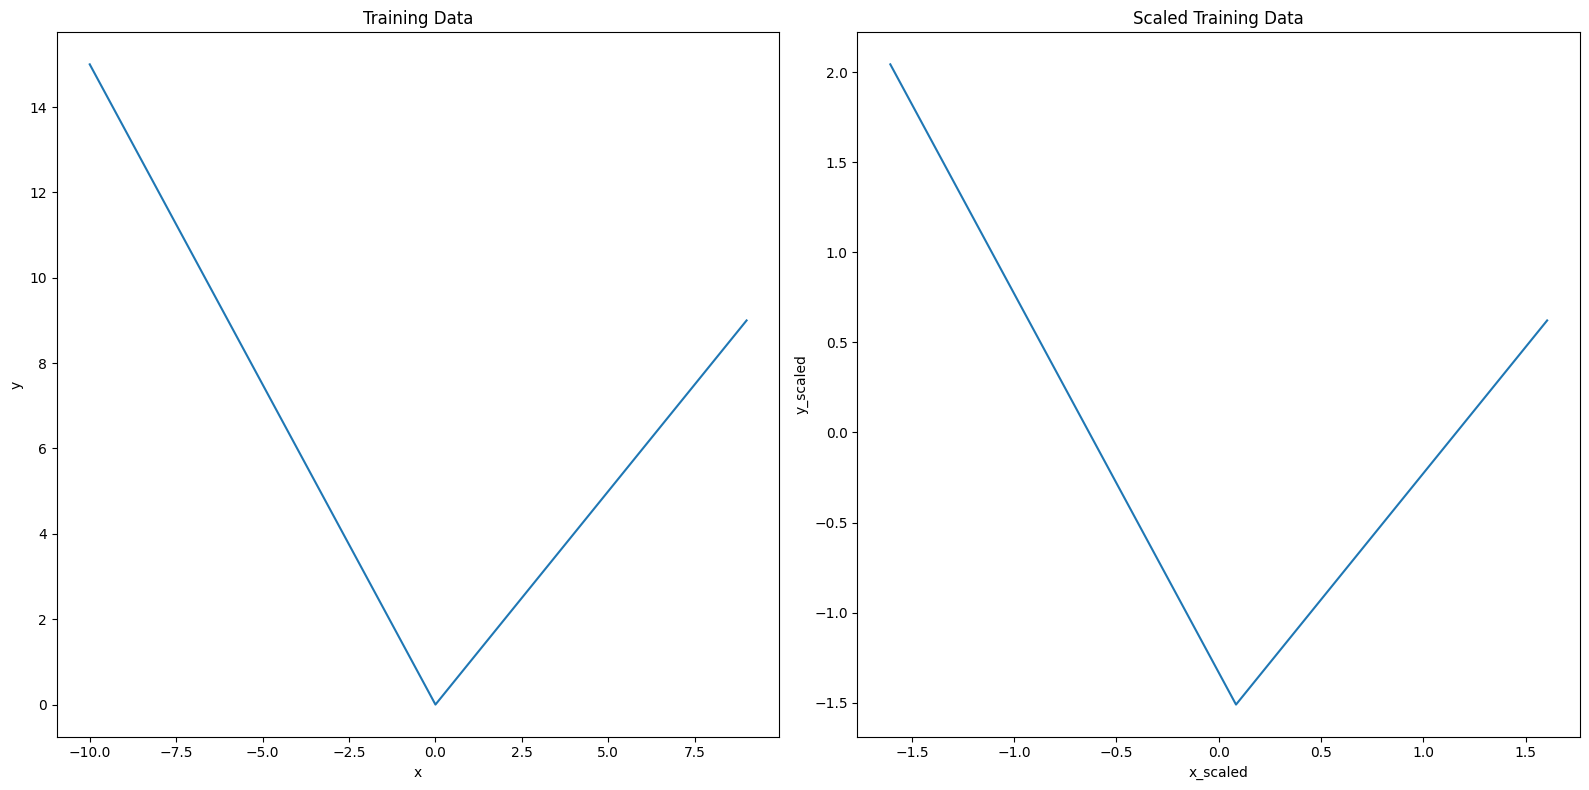

In [3]:
#retrieve input 'x' and output 'y' from the dataframe
x = df["x"]
y = df["y"]

#calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

#create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y");
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled");
ax2.set_title("Scaled Training Data")

plt.tight_layout()

In [4]:
#leaky relu neural network
net = Sequential(name='leaky_relu')
net.add(Input(1))
net.add(Dense(1, activation=LeakyReLU(alpha=alp)))
net.add(Dense(1))
net.compile(optimizer=Adam(), loss='mse')

2023-06-29 14:29:55.852377: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-29 14:29:55.852416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sherzoy-IdeaPad-5-14ITL05): /proc/driver/nvidia/version does not exist
2023-06-29 14:29:55.852868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
history = net.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=150)

Epoch 1/150
1/1 [==============================] - 0s 378ms/step - loss: 1.0011
Epoch 2/150
1/1 [==============================] - 0s 6ms/step - loss: 0.9973
Epoch 3/150
1/1 [==============================] - 0s 3ms/step - loss: 0.9934
Epoch 4/150
1/1 [==============================] - 0s 3ms/step - loss: 0.9896
Epoch 5/150
1/1 [==============================] - 0s 7ms/step - loss: 0.9858
Epoch 6/150
1/1 [==============================] - 0s 4ms/step - loss: 0.9821
Epoch 7/150
1/1 [==============================] - 0s 3ms/step - loss: 0.9783
Epoch 8/150
1/1 [==============================] - 0s 7ms/step - loss: 0.9746
Epoch 9/150
1/1 [==============================] - 0s 3ms/step - loss: 0.9710
Epoch 10/150
1/1 [==============================] - 0s 4ms/step - loss: 0.9673
Epoch 11/150
1/1 [==============================] - 0s 6ms/step - loss: 0.9637
Epoch 12/150
1/1 [==============================] - 0s 3ms/step - loss: 0.9601
Epoch 13/150
1/1 [==============================] - 0s 3ms/

In [6]:
assert(net.layers[0].get_config()['activation']['config']['alpha'] == alp)

In [7]:
#net
y_predict_scaled_leaky = net.predict(x=df['x_scaled'])
y_predict_leaky = y_predict_scaled_leaky*(std_data['y']) + mean_data['y']

1/1 [==============================] - 0s 80ms/step


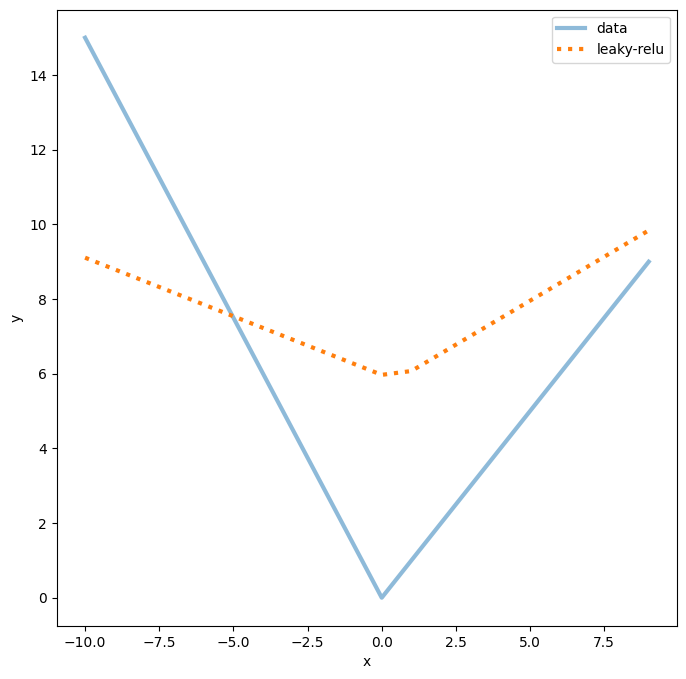

In [8]:
#create a single plot with the original data and each neural network's predictions
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
ax.plot(x,y_predict_leaky,linewidth = 3.0,linestyle="dotted",label = "leaky-relu")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [9]:
#create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

#create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

Scaled input bounds:  {0: (-1.6057930839841814, 1.6057930839841814)}


In [10]:
net_relu_leaky = keras_reader.load_keras_sequential(net,scaler,input_bounds)

model_bigm = pyo.ConcreteModel()
model_bigm.x = pyo.Var(initialize = 0)
model_bigm.y = pyo.Var(initialize = 0)
model_bigm.obj = pyo.Objective(expr=(model_bigm.y))
model_bigm.nn = OmltBlock()

formulation4_bigm = ReluBigMFormulation(net_relu_leaky)
model_bigm.nn.build_formulation(formulation4_bigm)

@model_bigm.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model_bigm.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_4_bigm = pyo.SolverFactory('gams:cbc').solve(model_bigm, tee=False)
solution_4_bigm = (pyo.value(model_bigm.x),pyo.value(model_bigm.y))

ERROR: Rule failed when generating expression for Constraint
    nn.layer[140268968260848].dense_layer with index 0:
    InfeasibleConstraintException: Variable has a lower bound which is larger
    than its upper bound: nn.layer[140268968260080].z[0]
ERROR: Constructing component 'nn.layer[140268968260848].dense_layer' from
    data=None failed: InfeasibleConstraintException: Variable has a lower
    bound which is larger than its upper bound: nn.layer[140268968260080].z[0]


InfeasibleConstraintException: Variable has a lower bound which is larger than its upper bound: nn.layer[140268968260080].z[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


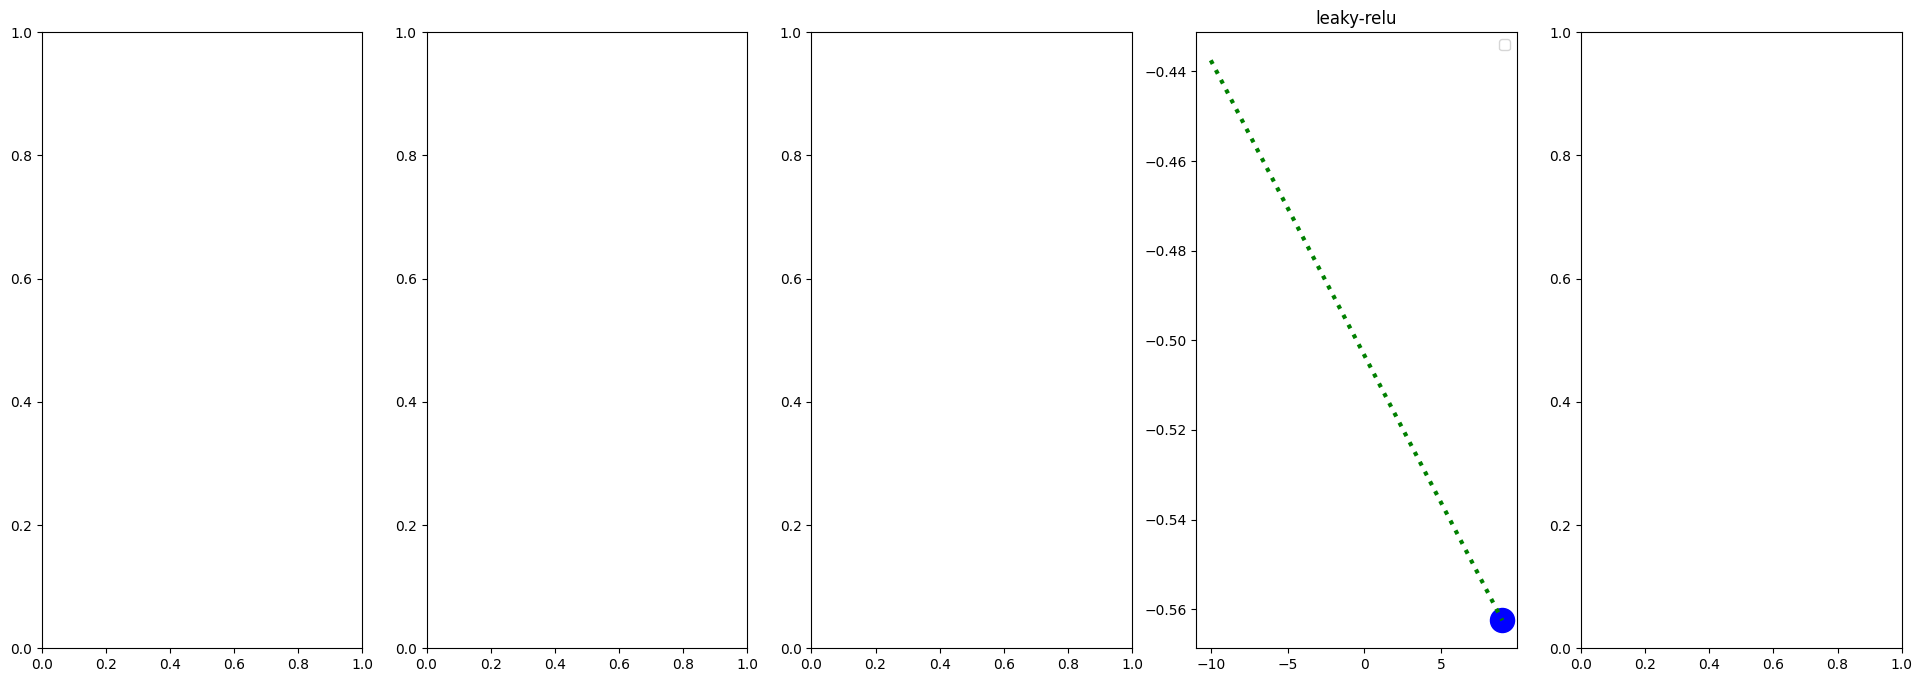

In [ ]:
#create a plot with 4 subplots
fig,axs = plt.subplots(1,5,figsize = (24,8))

#net - leaky relu 
axs[3].plot(x,y_predict_leaky,linewidth = 3.0,linestyle="dotted",color = "green")
axs[3].set_title("leaky-relu")
axs[3].scatter([solution_4_bigm[0]],[solution_4_bigm[1]],color = "blue",s = 300)
axs[3].legend()
